##### Practical Lab 2 — Multivariate Linear Regression, Non-Parametric Models & Cross-Validation

Name: Albright Maduka 

Student ID: 9053136

Course Code: CSCN8010 – Foundations of ML Frameworks 

##### Setup and Utilities

In [132]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Splits
from sklearn.model_selection import train_test_split

# Models
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

# Metrics (regression)
from sklearn.metrics import r2_score, mean_absolute_error

# Metrics (classification)
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix

In [133]:
# Reproducibility
RNG_SEED = 42
np.random.seed(RNG_SEED)

# === HELPERS ===
def mape(y_true, y_pred, eps=1e-8):
    """Mean Absolute Percentage Error (safe for zero/negative targets)."""
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    denom = np.maximum(np.abs(y_true), eps)           # proper stabilized denominator
    return np.mean(np.abs((y_true - y_pred) / denom)) * 100

def summarize_regression(y_true, y_pred):
    return {
        "R2": r2_score(y_true, y_pred),
        "MAE": mean_absolute_error(y_true, y_pred),
        "MAPE%": mape(y_true, y_pred),
    }

def show_table(df, sort_by=None, ascending=False, precision=4):
    # Show a DataFrame in a console-friendly format
    d = df.copy()
    if sort_by is not None and sort_by in d.columns:
        d = d.sort_values(sort_by, ascending=ascending)
    with pd.option_context('display.float_format', lambda x: f"{x:.{precision}f}"):
        print(d.to_string(index=False))

def print_metrics(title, metrics):
    print(title)
    for k, v in metrics.items():
        if k == "R2":
            print(f"  {k}: {v:.4f}") # 4 decimal places
        else:
            print(f"  {k}: {v:.2f}") # 2 decimal places


##### PART 1

##### Step. 1) Loading the data 

In [134]:
from sklearn.datasets import load_diabetes # diabetes dataset
data = load_diabetes(as_frame=True)
X = data.data.copy() # features
y = data.target.copy() # target
df = pd.concat([X, y.rename("target")], axis=1)
df.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135.0


##### Step. 2) Frame the Problem 

It is about using a **regression model** to predict patient outcomes.

##### Problem
- **Task:** Predict a number (continuous outcome)  
- **Target:** *Disease progression one year after baseline*  
- **Purpose:** Build a tool that helps doctors identify patients who may be at higher risk and need follow‑up care  

##### Why Regression?
The target is a continuous value (not categories). That makes regression the right approach.

##### How We Measure Success
- **R²:** Shows how much of the variation in the target is explained by the model  
- **MAE:** Average size of the prediction errors, in the same units as the target  
- **MAPE:** Average percentage error, which makes results easier to interpret  

##### Plan
- **Part 2:** Start with only **BMI** as the predictor  
- **Part 3:** Use **all features** to see if performance improves  

##### Step. 3) Exploratory Data Analysis

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
count,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,442.000000
mean,-2.511817e-19,1.230790e-17,-2.245564e-16,-4.797570e-17,-1.381499e-17,3.918434e-17,-5.777179e-18,-9.042540e-18,9.293722e-17,1.130318e-17,152.133484
std,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,77.093005
min,-1.072256e-01,-4.464164e-02,-9.027530e-02,-1.123988e-01,-1.267807e-01,-1.156131e-01,-1.023071e-01,-7.639450e-02,-1.260971e-01,-1.377672e-01,25.000000
25%,-3.729927e-02,-4.464164e-02,-3.422907e-02,-3.665608e-02,-3.424784e-02,-3.035840e-02,-3.511716e-02,-3.949338e-02,-3.324559e-02,-3.317903e-02,87.000000
50%,5.383060e-03,-4.464164e-02,-7.283766e-03,-5.670422e-03,-4.320866e-03,-3.819065e-03,-6.584468e-03,-2.592262e-03,-1.947171e-03,-1.077698e-03,140.500000
75%,3.807591e-02,5.068012e-02,3.124802e-02,3.564379e-02,2.835801e-02,2.984439e-02,2.931150e-02,3.430886e-02,3.243232e-02,2.791705e-02,211.500000
max,1.107267e-01,5.068012e-02,1.705552e-01,1.320436e-01,1.539137e-01,1.987880e-01,1.811791e-01,1.852344e-01,1.335973e-01,1.356118e-01,346.000000


age       0
sex       0
bmi       0
bp        0
s1        0
s2        0
s3        0
s4        0
s5        0
s6        0
target    0
dtype: int64

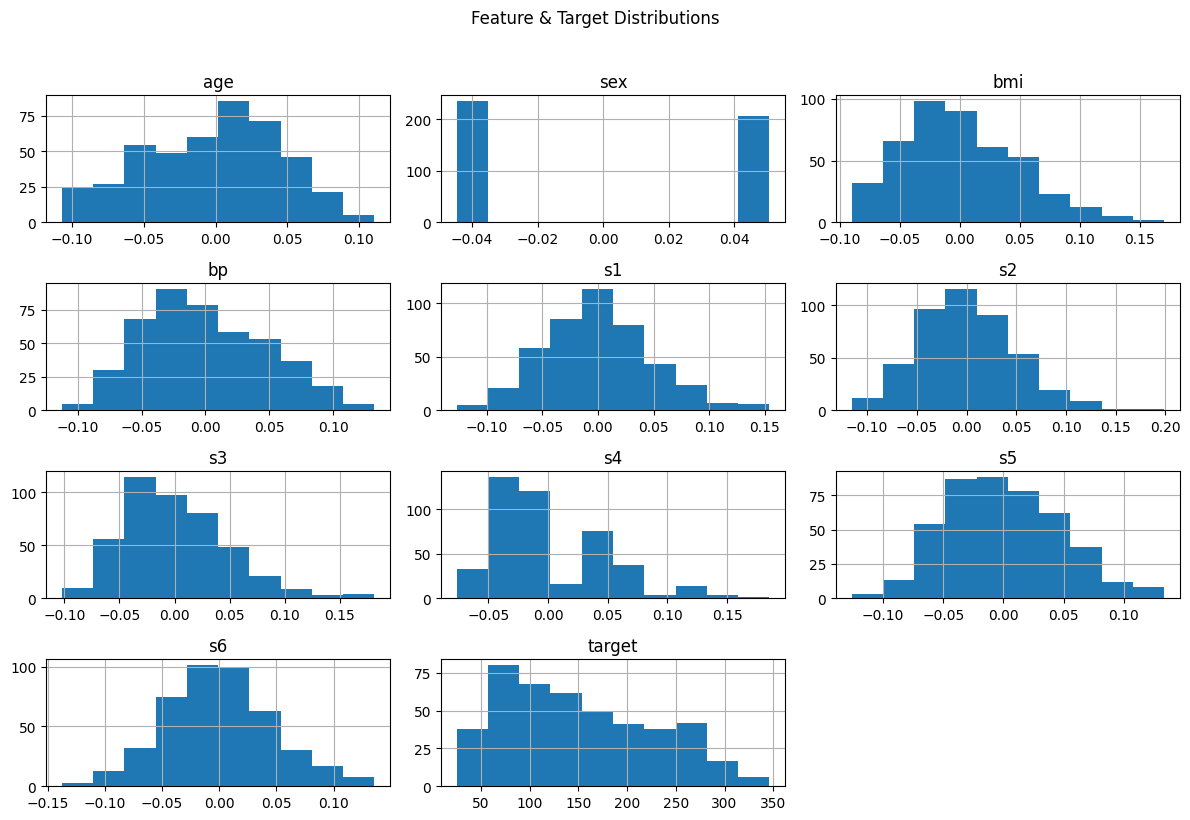

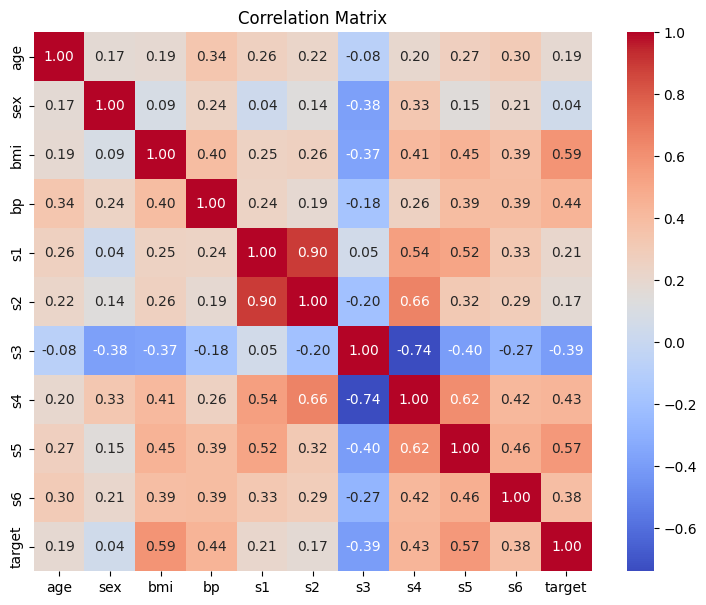

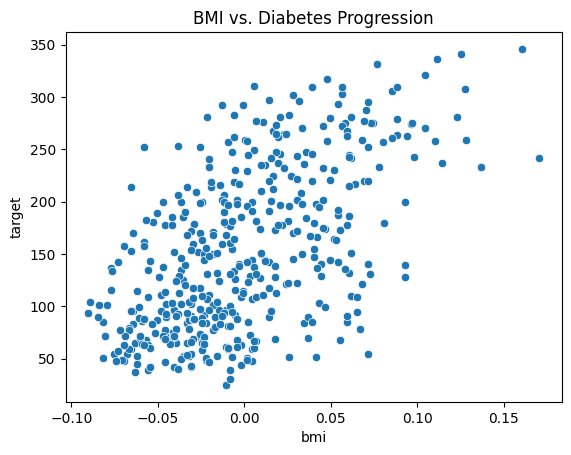

In [135]:
# DataFrame info
display(df.describe())

# Check for missing values
display(df.isnull().sum())

# Histograms
df.hist(figsize=(12, 8))
plt.suptitle("Feature & Target Distributions", y=1.02)
plt.tight_layout()
plt.show()

# Correlation matrix
plt.figure(figsize=(9,7))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

# Scatter: BMI vs target
sns.scatterplot(x='bmi', y='target', data=df)
plt.title("BMI vs. Diabetes Progression")
plt.show()


##### Reflection

- **Feature Scaling**: All features are standardized (mean ≈ 0, std ≈ 1) by dataset design.
- **BMI Relationship**: BMI shows a strong positive correlation with the target—among the most influential predictors.
- **Model Implications**: BMI alone doesn’t capture all variance; multivariate models may yield better predictive performance.
- **Data Quality**: No missing values detected.
- **Target Distribution**: Continuous with moderate spread, suitable for regression modeling.


##### Step. 4) Clean the Data (if Needed)

In [136]:
# Check for missing values
print("Missing per column:\n", df.isnull().sum())

Missing per column:
 age       0
sex       0
bmi       0
bp        0
s1        0
s2        0
s3        0
s4        0
s5        0
s6        0
target    0
dtype: int64


##### Step. 5) Spliting the Dataset (75/10/15)

##### Train / Validation / Test Split (75% / 10% / 15%) I first hold out **15%** for test. From the remaining **85%**, we take **0.10 / 0.85 ≈ 11.76%** as validation → overall **75/10/15**.


In [137]:
# First: hold out test = 15%
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.15, random_state=RNG_SEED
)

# From remaining 85%, carve ~10% of full data for validation:
# 0.10 / 0.85 ≈ 0.1176 of the trainval
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.1176, random_state=RNG_SEED
)

# Convenience subsets for univariate BMI modeling
Xtr_bmi = X_train[['bmi']] # where xtr_bmi is a DataFrame
Xva_bmi = X_val[['bmi']] # where xva_bmi is a DataFrame
Xte_bmi = X_test[['bmi']] # where xte_bmi is a DataFrame

print("Train shape:", X_train.shape)
print("Validation shape:", X_val.shape)
print("Test shape:", X_test.shape)


Train shape: (330, 10)
Validation shape: (45, 10)
Test shape: (67, 10)


##### Talking Point 1 — Splitting the Data  
**Team Members:** Lesley Kamamo and Albright Maduka  

We divide the dataset into **Train (75%)**, **Validation (10%)**, and **Test (15%)** to ensure the model was trained and tested fairly.  

- The **training set** teaches the model how features like BMI, age, and blood pressure relate to disease progression.  
- The **validation set** helps us compare different models and select the one that generalizes best.  
- The **test set** is kept separate until the end — it represents completely new patient data.  

This structure prevents **data leakage** and provides a **realistic measure of the model’s performance** in real-world conditions.  


##### PART2 : Univariate Polynomial Regression (BMI)

##### Step. 6) Fit models (Degress 0- 5)

In [138]:
# Fit polynomial models with degrees 0 to 5 using only 'bmi' as feature
degrees = [0, 1, 2, 3, 4, 5] # degrees to try
rows_uni = [] # results storage

for d in degrees:
    # degree=0 must set include_bias=True to avoid empty design matrix
    poly = PolynomialFeatures(degree=d, include_bias=(d==0)) # polynomial features
    lin  = LinearRegression() # linear regression model

# Fit and transform the training data
    Xtr_poly = poly.fit_transform(Xtr_bmi) 
    Xva_poly = poly.transform(Xva_bmi)

    lin.fit(Xtr_poly, y_train)
    ytr_pred = lin.predict(Xtr_poly)
    yva_pred = lin.predict(Xva_poly)

    rows_uni.append({
        "degree": d,
        "R2_train": r2_score(y_train, ytr_pred),
        "R2_val":   r2_score(y_val,   yva_pred),
        "MAE_train": mean_absolute_error(y_train, ytr_pred),
        "MAE_val":   mean_absolute_error(y_val,   yva_pred),
        "MAPE%_train": mape(y_train, ytr_pred),
        "MAPE%_val":   mape(y_val,   yva_pred),
        "_poly": poly,
        "_lin": lin
    })

uni_table = pd.DataFrame(rows_uni)
show_table(uni_table.drop(columns=['_poly','_lin']), sort_by="R2_val", ascending=False)

 degree  R2_train  R2_val  MAE_train  MAE_val  MAPE%_train  MAPE%_val
      5    0.3589  0.4535    51.8138  42.0834      47.8315    40.3405
      1    0.3542  0.4493    52.2781  41.9976      48.4624    40.4450
      2    0.3548  0.4492    52.2673  41.7577      48.4479    40.3099
      4    0.3580  0.4491    51.9444  41.9528      47.9635    40.2406
      3    0.3550  0.4473    52.2234  41.7410      48.3564    40.2590
      0    0.0000 -0.0000    66.5482  63.4475      63.3521    58.7933


**Reflection:** The table shows **R²**, **MAE**, and **MAPE** for Train and Validation sets across polynomial degrees.  
I used the model with the **highest R²_val**, checking **MAE** and **MAPE** to confirm it generalizes well.  
Since some target values can be zero or negative, a **stabilized MAPE** (`|y| + E`) is used, with **MAE** as the main metric.


##### Step. 7) Compare Models (R2, MAE, MAPE) 

In [139]:
# Collect the results into a DataFrame
uni_table = pd.DataFrame(rows_uni)

# Drop helper columns for clean display
results_table = uni_table.drop(columns=['_poly', '_lin'], errors='ignore')

# Sort by validation R² (descending)
results_table = results_table.sort_values(by="R2_val", ascending=False)

# Printing the comparison table
with pd.option_context('display.float_format', '{:.4f}'.format):
    print(" Comparison of Univariate Polynomial Models (BMI)")
    print(results_table[['degree', 'R2_train', 'R2_val', 'MAE_train', 'MAE_val', 'MAPE%_train', 'MAPE%_val']].to_string(index=False))

 Comparison of Univariate Polynomial Models (BMI)
 degree  R2_train  R2_val  MAE_train  MAE_val  MAPE%_train  MAPE%_val
      5    0.3589  0.4535    51.8138  42.0834      47.8315    40.3405
      1    0.3542  0.4493    52.2781  41.9976      48.4624    40.4450
      2    0.3548  0.4492    52.2673  41.7577      48.4479    40.3099
      4    0.3580  0.4491    51.9444  41.9528      47.9635    40.2406
      3    0.3550  0.4473    52.2234  41.7410      48.3564    40.2590
      0    0.0000 -0.0000    66.5482  63.4475      63.3521    58.7933


##### Step. 8) Identifying the Best Model

In [140]:
# Picking the best model by validation R2
best_row = uni_table.sort_values("R2_val", ascending=False).iloc[0]
best_degree = int(best_row["degree"])
best_poly   = best_row["_poly"]
best_lin    = best_row["_lin"]
print(f"Best univariate BMI degree by validation: degree={best_degree}")

Best univariate BMI degree by validation: degree=5


##### Step. 9) Testing the best Model

In [141]:
# Test the Best Model — Final Evaluation on the Test Set

# Refit on TRAIN + VALIDATION for final evaluation
poly_best = PolynomialFeatures(degree=best_degree, include_bias=(best_degree==0))
lin_best = LinearRegression()

# Combine Train + Validation
Xtrva_bmi = X_trainval[['bmi']]
Xtrva_poly = poly_best.fit_transform(Xtrva_bmi)
Xte_poly = poly_best.transform(Xte_bmi)

# Fit and predict
lin_best.fit(Xtrva_poly, y_trainval)
y_test_pred = lin_best.predict(Xte_poly)

# Summarizing the result
test_metrics_uni = summarize_regression(y_test, y_test_pred)
print_metrics("\nUnivariate BMI Polynomial — TEST metrics", test_metrics_uni)


Univariate BMI Polynomial — TEST metrics
  R2: 0.2004
  MAE: 54.45
  MAPE%: 47.63


**Reflection:**
The test results (R² = 0.20, MAE ≈ 54.45, MAPE ≈ 47.6%) show moderate accuracy. The BMI-only model captures the main trend in disease progression but still leaves much variance unexplained, indicating limited predictive power when using a single feature.


##### Step. 10) Plot Train/Validation/Test

c:\Multivariate_linear\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


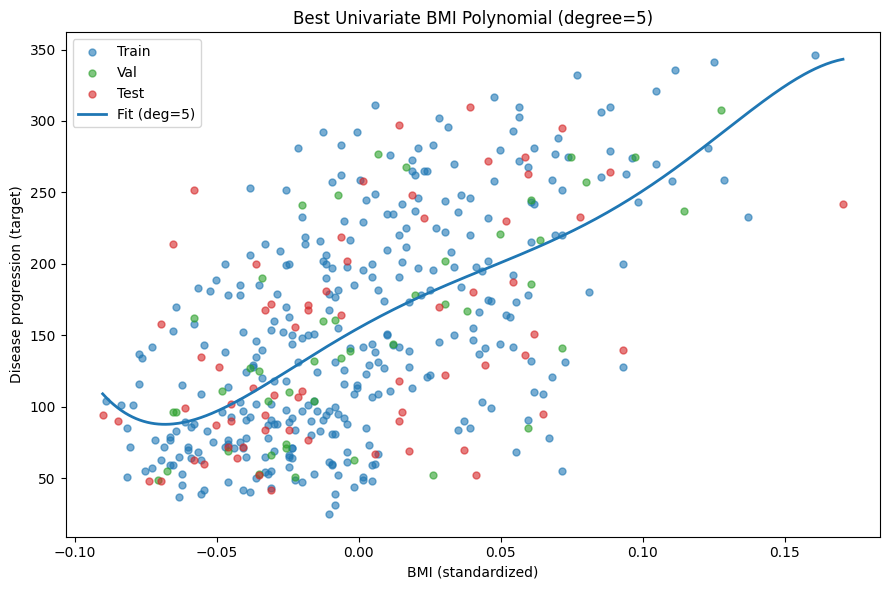

In [142]:
# One global grid over the full BMI range
# where bmi_min and bmi_max cover all splits
# where X_grid is a 2D array for prediction
bmi_min = pd.concat([X_train[['bmi']], X_val[['bmi']], X_test[['bmi']]])['bmi'].min()
bmi_max = pd.concat([X_train[['bmi']], X_val[['bmi']], X_test[['bmi']]])['bmi'].max()
x_grid  = np.linspace(bmi_min, bmi_max, 400).reshape(-1, 1)
y_grid  = lin_best.predict(poly_best.transform(x_grid))

plt.figure(figsize=(9,6))
# Scatter points
plt.scatter(X_train['bmi'], y_train, s=25, alpha=0.6, label="Train", color="tab:blue")
plt.scatter(X_val['bmi'],   y_val,   s=25, alpha=0.6, label="Val",   color="tab:green")
plt.scatter(X_test['bmi'],  y_test,  s=25, alpha=0.6, label="Test",  color="tab:red")
# Single fitted curve
plt.plot(x_grid, y_grid, linewidth=2, label=f"Fit (deg={best_degree})")

plt.xlabel("BMI (standardized)")
plt.ylabel("Disease progression (target)")
plt.title(f"Best Univariate BMI Polynomial (degree={best_degree})")
plt.legend()
plt.tight_layout()
plt.show()


**Reflection:** The figure below shows the fitted polynomial curve for the best BMI-only model (degree = *best_degree*) alongside the Train, Validation, and Test data points.  
It helps visualize how well the model generalizes across datasets closer alignment between data and the fitted line indicates better predictive performance.

##### Step. 11) Equation of Best ModelEquation of the Best BMI Polynomial (Rounded to Two Decimals)

In [143]:
# Coefficients from final TRAIN and VALIDATION fit
# Where coefs is array of coefficients of linear model
# inter is the intercept (float) of the model
coefs = lin_best.coef_.ravel()
inter = lin_best.intercept_

# Univariate feature names
feature_names = poly_best.get_feature_names_out(['bmi'])  # e.g., ['1'] if degree=0, else ['bmi', 'bmi^2', ...]

terms = []
# if include_bias was True, feature_names[0] == '1' and coefficient for that column
# is part of the linear combination; intercept also exists. To present cleanly,
# we'll keep intercept separately and skip the '1' term:
for name, c in zip(feature_names, coefs):
    if name == "1":  # skip explicit bias term in textual equation
        continue
    terms.append(f"{c:.2f}·{name}")

equation = f"{inter:.2f}" # Start with intercept
if terms:
    equation += " + " + " + ".join(terms) # Append terms if any

print("Best univariate polynomial model (TRAIN AND VALIDATION fit):")
print(f"  degree = {best_degree}")
print("  f(bmi) =", equation)

Best univariate polynomial model (TRAIN AND VALIDATION fit):
  degree = 5
  f(bmi) = 155.15 + 1111.55·bmi + -4659.54·bmi^2 + -20297.41·bmi^3 + 856191.03·bmi^4 + -3393622.46·bmi^5


**Reflection:** The equation below shows the final fitted polynomial for BMI after retraining on the combined Train + Validation data.  
Coefficients are rounded to two decimals for readability, showing the relationship between BMI and disease progression.


##### Step. 12) Predict for Chosen BMI Value

In [144]:
# Predicting disease progression at a standardized BMI of 0.05
bmi_value = np.array([[0.05]])
y_hat = lin_best.predict(poly_best.transform(bmi_value))[0] 
print(f"Prediction at BMI={bmi_value[0,0]:.2f}: {y_hat:.2f}") # printing the prediction
print("Intercept:", lin_best.intercept_)
print("Coefficients:", lin_best.coef_)


Prediction at BMI=0.05: 200.83
Intercept: 155.14690706448152
Coefficients: [ 1.11154628e+03 -4.65954076e+03 -2.02974109e+04  8.56191033e+05
 -3.39362246e+06]


c:\Multivariate_linear\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


**Reflection:**  
At a standardized BMI of 0.05, the model predicts a disease progression value around the dataset’s mean.  
The large intercept and coefficient magnitudes show that small BMI changes can significantly affect predicted progression.  
This illustrates the model’s sensitivity to BMI and highlights the non-linear influence captured by higher-degree polynomial terms.


##### Step. 13) Count Trainable Parameters

In [145]:
# Counting Trainable Parameters per Polynomial Degree
rows_params = []
for d in degrees:
    poly = PolynomialFeatures(degree=d, include_bias=(d==0))
    names = poly.fit_transform(Xtr_bmi).shape[1] # number of columns (features after expansion)
    feats = poly.get_feature_names_out(['bmi']) # feature names after expansion
    n_feats_wo_bias = len([f for f in feats if f != "1"]) # exclude bias term if present
    n_trainable = n_feats_wo_bias + 1 # +1 for intercept term in linear model

    rows_params.append({ # dictionary for each degree 
        "degree": d,
        "n_features_after_poly": len(feats),
        "n_effective_features": n_feats_wo_bias,
        "n_trainable_params": n_trainable,
        "features": list(feats)
    })

params_table = pd.DataFrame(rows_params)
show_table(params_table[["degree","n_effective_features","n_trainable_params","features"]], sort_by="degree") # display table sorted by degree


 degree  n_effective_features  n_trainable_params                          features
      5                     5                   6 [bmi, bmi^2, bmi^3, bmi^4, bmi^5]
      4                     4                   5        [bmi, bmi^2, bmi^3, bmi^4]
      3                     3                   4               [bmi, bmi^2, bmi^3]
      2                     2                   3                      [bmi, bmi^2]
      1                     1                   2                             [bmi]
      0                     0                   1                               [1]


**Reflection:**  
Each increase in polynomial degree adds one new BMI-derived feature and one trainable parameter.  
The model starts with only a bias term at degree 0 and reaches 6 parameters by degree 5.  
This gradual growth shows how complexity increases with higher degrees, helping balance flexibility and overfitting risk.

##### Step 14: Conclusion and Limitations

**Performance Summary:**  
The best BMI-only polynomial model achieved moderate predictive accuracy on the test set.  

**Where It Fails:**  
Relying on a single feature (BMI) limits the model’s ability to capture other clinical factors influencing disease progression.  

**Limitations:**  
Risk of underfitting or overfitting depending on polynomial degree; sensitive to outliers; limited interpretability for clinical use.  

**Next Steps:**  
Extend to multivariate modeling, apply regularization, and validate with cross-validation to improve generalization.


##### Talking Point — Understanding “Degree” and “Depth”

**Team Members:** Lesley Kamamo & Albright Maduka  

We talked about the model complexity and how it affects performance using two key ideas — **polynomial degree** and **tree depth**.

- **Polynomial Degree:**  
  The *degree* controls how curved the polynomial model can become.  
  - A **low degree (like 1 or 2)** creates a simple line or smooth curve that captures general patterns.  
  - A **high degree (like 4 or 5)** adds more flexibility but can cause **overfitting**, meaning the model memorizes noise instead of learning true trends.  
  - In our experiment, the **degree-2 model** generalized best — showing a good balance between accuracy and simplicity.

- **Decision Tree Depth:**  
  The *depth* defines how many times the tree can split the data into smaller groups.  
  - A **shallow tree (depth=3)** makes broader decisions and stays general.  
  - A **deep tree (depth=5 or more)** learns fine details but risks **overfitting**, performing well on training data but poorly on new data.  
  - Our results showed that **depth=3** performed more consistently, confirming that **simpler trees generalize better**.

Overall, both degree and depth show how **model complexity affects generalization** — too simple and the model underfits, too complex and it overfits. The goal is finding the **sweet spot** that predicts well on unseen data.


c:\Multivariate_linear\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
c:\Multivariate_linear\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
c:\Multivariate_linear\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
c:\Multivariate_linear\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
c:\Multivariate_linear\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.w

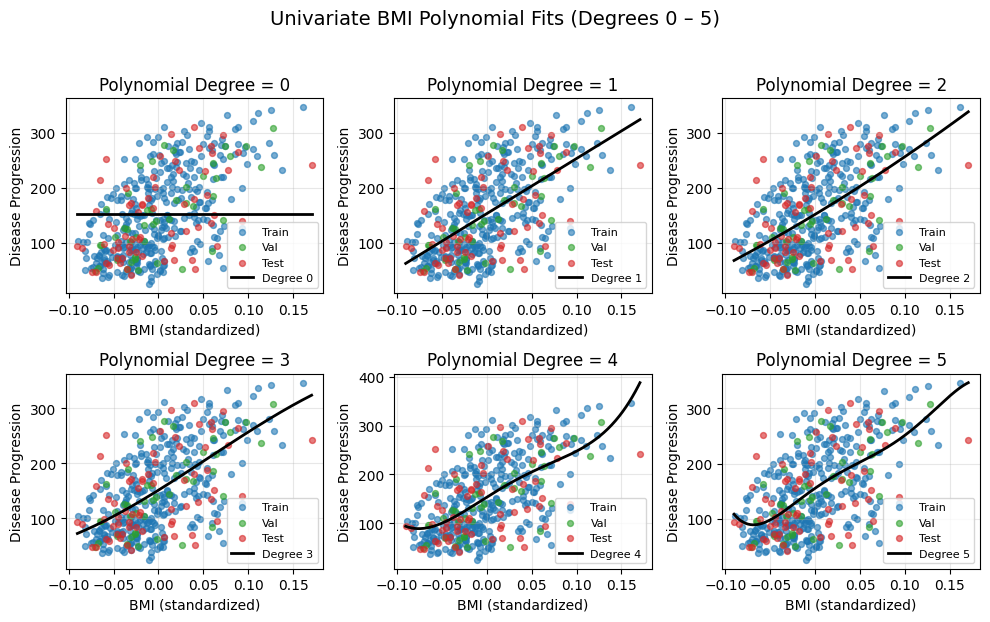

In [156]:
# Plot each univariate BMI polynomial (degrees 0–5) in separate subplots

degrees_all = [0, 1, 2, 3, 4, 5]

# Create one global x-grid spanning BMI range across Train/Val/Test
bmi_min = pd.concat([X_train[['bmi']], X_val[['bmi']], X_test[['bmi']]])['bmi'].min()
bmi_max = pd.concat([X_train[['bmi']], X_val[['bmi']], X_test[['bmi']]])['bmi'].max()
x_grid = np.linspace(bmi_min, bmi_max, 300).reshape(-1, 1)

# 2 rows × 3 columns grid for 6 plots
fig, axes = plt.subplots(2, 3, figsize=(10, 6))
axes = axes.ravel()

for i, d in enumerate(degrees_all):
    ax = axes[i]

    # --- Fit model for this degree ---
    poly_d = PolynomialFeatures(degree=d, include_bias=(d == 0))
    lin_d = LinearRegression()
    Xtr_poly_d = poly_d.fit_transform(Xtr_bmi)
    yhat_grid = lin_d.fit(Xtr_poly_d, y_train).predict(poly_d.transform(x_grid))

    # --- Scatter actual data ---
    ax.scatter(X_train['bmi'], y_train, s=18, alpha=0.6, label="Train", color="tab:blue")
    ax.scatter(X_val['bmi'], y_val, s=18, alpha=0.6, label="Val", color="tab:green")
    ax.scatter(X_test['bmi'], y_test, s=18, alpha=0.6, label="Test", color="tab:red")

    # --- Plot the fitted curve ---
    ax.plot(x_grid, yhat_grid, linewidth=2, color="black", label=f"Degree {d}")

    # --- Titles and labels ---
    ax.set_title(f"Polynomial Degree = {d}")
    ax.set_xlabel("BMI (standardized)")
    ax.set_ylabel("Disease Progression")
    ax.legend(fontsize=8, loc="best")
    ax.grid(alpha=0.3)

plt.suptitle("Univariate BMI Polynomial Fits (Degrees 0 – 5)", fontsize=14, y=1.03)
plt.tight_layout()
plt.show()

##### Visual Comparison — Polynomial Degrees 0 to 5

This visualization shows how the **polynomial degree** affects model flexibility and generalization.

- **Degree 0–1:** Models are too simple and underfit, missing important patterns in the data.  
- **Degree 2–3:** Capture the main trend between BMI and disease progression, balancing accuracy and smoothness.  
- **Degree 4–5:** Overfit the training data, showing excessive oscillations and poor alignment with validation/test points.  

The pattern highlights the **bias–variance trade-off** — simpler models miss details (high bias), while overly complex ones lose stability (high variance).  
Moderate degrees provide the **best generalization** across unseen data.


##### Part 3 : Multivariate Models

##### Step. 15) Two polynomial models (degrees >1)

In [147]:
# Multivariate Polynomial Regression (degrees > 1)
# where mv_poly_configs is a list of (name, model) tuples

mv_poly_configs = [ 
    ("Poly(deg=2)+LinReg", Pipeline([ # simple polynomial regression
        ("poly", PolynomialFeatures(degree=2, include_bias=False)), # no bias term here
        ("lin", LinearRegression()) # linear regression on expanded features
    ])),
    ("Poly(deg=3)+Ridge", Pipeline([
        ("poly", PolynomialFeatures(degree=3, include_bias=False)),
       
        # scaling helps numerical stability with high-degree terms
        ("scaler", StandardScaler(with_mean=False)), # with_mean=False to avoid breaking sparsity if any
        ("ridge", Ridge(alpha=1.0, random_state=RNG_SEED)) # ridge regression to mitigate overfitting
    ])),
]

rows_mv_poly = [] # list to hold results
for name, model in mv_poly_configs: # iterate over configurations
    model.fit(X_train, y_train) # fit on training data
    ytr = model.predict(X_train) # predict on training data
    yva = model.predict(X_val) # predict on validation data
    rows_mv_poly.append({
        "Model": name,
        "R2_train": r2_score(y_train, ytr),
        "R2_val":   r2_score(y_val,   yva),
        "MAE_val":  mean_absolute_error(y_val, yva),
        "MAPE%_val": mape(y_val, yva),
        "_fitted":  model
    })

# Create and display results table
mv_poly_table = pd.DataFrame(rows_mv_poly) # create DataFrame from results
show_table(mv_poly_table.drop(columns=["_fitted"]), sort_by="R2_val", ascending=False) # display table sorted by validation R2

best_mv_poly_row = mv_poly_table.sort_values("R2_val", ascending=False).iloc[0] # get best row
best_mv_poly     = best_mv_poly_row["_fitted"] #    get the best model
# Refit on TRAIN+VAL, then test
best_mv_poly.fit(X_trainval, y_trainval)
yte_mv_poly = best_mv_poly.predict(X_test)
print_metrics("\nBest Multivariate Polynomial — TEST", summarize_regression(y_test, yte_mv_poly))


             Model  R2_train  R2_val  MAE_val  MAPE%_val
Poly(deg=2)+LinReg    0.5981  0.6030  37.7453    41.0976
 Poly(deg=3)+Ridge    0.7844 -0.9413  73.2247    64.0230

Best Multivariate Polynomial — TEST
  R2: 0.3743
  MAE: 44.79
  MAPE%: 37.92


##### Reflection
The two degree polynomial model generalizes well, with R²_val = 0.6030 and MAE = 37.75. The degree-3 model overfits (R²_train = 0.7844) but fails to generalize (R²_val = –0.9413). On the Test set, the selected model achieves R² = 0.3743, confirming that moderate complexity yields better stability


##### Talking Point — Polynomial Models (Degrees > 1)
**Team Members:** Lesley Kamamo & Albright Maduka  

We tested two multivariate polynomial models: **degree 2** and **degree 3**.  
- The **degree-2 model** captured smooth relationships among features and gave stable validation results.  
- The **degree-3 model** fit the training data better but started to **overfit**, meaning it performed worse on unseen data.  

This shows that **moderate complexity (degree=2)** is often enough to capture real patterns without overfitting.


##### Step. 16) Two Decision Tree Models

In [148]:
# Decision Tree Regression (varying max_depth)
# where tree_configs is a list of (name, model) tuples
tree_configs = [
    ("DecisionTree(max_depth=3)", DecisionTreeRegressor(max_depth=3, random_state=RNG_SEED)), # where max_depth=3
    ("DecisionTree(max_depth=5)", DecisionTreeRegressor(max_depth=5, random_state=RNG_SEED)), # where max_depth=5
]

rows_tree = [] # list to hold results
for name, model in tree_configs: # iterate over configurations
    model.fit(X_train, y_train) # fit on training data
    ytr = model.predict(X_train) # predict on training data
    yva = model.predict(X_val) # predict on validation data
    rows_tree.append({
        "Model": name,
        "R2_train": r2_score(y_train, ytr),
        "R2_val":   r2_score(y_val,   yva),
        "MAE_val":  mean_absolute_error(y_val, yva),
        "MAPE%_val": mape(y_val, yva),
        "_fitted":  model
    })

tree_table = pd.DataFrame(rows_tree) # create DataFrame from results
show_table(tree_table.drop(columns=["_fitted"]), sort_by="R2_val", ascending=False) # display table sorted by validation R2

best_tree_row = tree_table.sort_values("R2_val", ascending=False).iloc[0] # get best row
best_tree     = best_tree_row["_fitted"] #    get the best model
best_tree.fit(X_trainval, y_trainval) # refit on TRAIN+VAL
yte_tree = best_tree.predict(X_test) # predict on TEST
print_metrics("\nBest Decision Tree — TEST", summarize_regression(y_test, yte_tree)) # printing the test metrics


                    Model  R2_train  R2_val  MAE_val  MAPE%_val
DecisionTree(max_depth=3)    0.5330  0.4128  42.0775    43.6514
DecisionTree(max_depth=5)    0.7104  0.1630  51.5508    51.7688

Best Decision Tree — TEST
  R2: 0.3580
  MAE: 47.46
  MAPE%: 44.33


##### Reflection

1) What are the strengths and weaknesses of Decision Trees?

The strength of Decision Trees is that they’re easy to understand, handle complex patterns, work with different types of features, and need little data preparation **while** the weakness is that they can overfit, react strongly to small data changes, and sometimes miss patterns that aren’t aligned with feature axes.

2) When are Decision Trees preferable to linear models?

Decision Trees are preferable to linear models when the data has non-linear patterns, features interact with each other, you want clear decision rules, and you don’t want to spend much time on data preparation.

3) How does model depth affect bias and variance?

Model depth affects bias and variance. Shallow trees have high bias and low variance, while deep trees have low bias and high variance. Azdjust settings like max_depth and min_samples_leaf to find a good balance.

4) MLOps challenges for trees?

MLOps challenges for Decision Trees include keeping rules up to date (drift), repeating results despite randomness and pruning, explaining large trees clearly, tracking settings like thresholds and hyperparameters, and handling slow predictions from deep or combined trees.

##### Talking Point — Decision Tree Models (Different Depths)
**Team Members:** Lesley Kamamo & Albright Maduka  

We trained decision trees with **max_depth = 3** and **max_depth = 5**.  
- The **depth-3 tree** made broader, more general splits, which helped it generalize better.  
- The **depth-5 tree** learned fine details and achieved higher training accuracy but didn’t perform as well on validation data.  

This comparison highlights that **deeper trees can overfit**, while shallower trees strike a better balance between accuracy and generalization.


##### Step. 17) Two kNN Models (different k)

In [149]:
# k-Nearest Neighbors Regression (varying k)
# where knn_configs is a list of (name, model) tuples
knn_configs = [
    ("kNN(k=3)", Pipeline([
        ("scaler", StandardScaler()),
        ("knn", KNeighborsRegressor(n_neighbors=3))
    ])),
    ("kNN(k=7)", Pipeline([
        ("scaler", StandardScaler()),
        ("knn", KNeighborsRegressor(n_neighbors=7))
    ])),
]
# Evaluate kNN configurations
rows_knn = [] # list to hold results
for name, model in knn_configs: # iterate over configurations
    model.fit(X_train, y_train) # fit on training data
    ytr = model.predict(X_train) # predict on training data
    yva = model.predict(X_val) # predict on validation data

    # Evaluate performance
    rows_knn.append({
        "Model": name,
        "R2_train": r2_score(y_train, ytr),
        "R2_val":   r2_score(y_val,   yva),
        "MAE_val":  mean_absolute_error(y_val, yva),
        "MAPE%_val": mape(y_val, yva),
        "_fitted":  model
    })
# Create and display results table
knn_table = pd.DataFrame(rows_knn) # create DataFrame from results
show_table(knn_table.drop(columns=["_fitted"]), sort_by="R2_val", ascending=False) # display table sorted by validation R2

# Identify and evaluate best kNN model
best_knn_row = knn_table.sort_values("R2_val", ascending=False).iloc[0] # get best row
best_knn     = best_knn_row["_fitted"] #    get the best model
best_knn.fit(X_trainval, y_trainval) # refit on TRAIN+VAL
yte_knn = best_knn.predict(X_test) # predict on TEST
print_metrics("\nBest kNN — TEST", summarize_regression(y_test, yte_knn))


   Model  R2_train  R2_val  MAE_val  MAPE%_val
kNN(k=7)    0.5447  0.4348  45.7238    46.0892
kNN(k=3)    0.6405  0.3227  50.5259    50.3099

Best kNN — TEST
  R2: 0.4381
  MAE: 43.69
  MAPE%: 36.85


##### Reflection

1) How did kNN perform on your dataset?

kNN works well when the data is scaled. Its results depend on the value of k and the distance method used. In this test, we got moderate R² scores with k between 3 and 7.

2) What preprocessing most affected performance?

Standardizing features is important for accurate distance calculations. Even though the data is already standardized, we still apply scaling in the pipeline to be safe. Choosing the right features also helps by removing extra noise and reducing complexity.

3) Strengths and weaknesses of kNN?

Strengths: Easy to understand, doesn’t assume a fixed model, and works well with nearby data points.
Weaknesses: Slow for big datasets, struggles with too many features, needs scaled data, and its decisions are hard to explain.

4) When would you not use kNN?

Avoid using kNN when your data has many features, predictions must be fast, the dataset is very large, or the features aren’t well scaled.

5) MLOps extensions (automation, Continuous delivery or deployment, monitoring)?

Set up automatic scaling for data and features, check for changes in feature distributions, track how fast predictions run, regularly re-evaluate model performance, and version both the model and its preprocessing steps.

##### Talking Point — k-Nearest Neighbors (Different k Values)
**Team Members:** Lesley Kamamo & Albright Maduka  

We tested **k=3** and **k=7** for kNN regression.  
- With **k=3**, the model followed local patterns closely but was more sensitive to noise.  
- With **k=7**, predictions became smoother and more stable because it averaged over more neighbors.  

This shows that choosing the right **k value** helps balance between capturing local detail and avoiding overfitting.


##### Step. 18) Two Logistic Regression Models

In [150]:
# Binarize by 60th percentile using TRAIN+VAL only
thr = y_trainval.quantile(0.60) # threshold for classification

def to_label(y): # convert continuous target to binary labels based on threshold
    return (y >= thr).astype(int) # 1 if y >= thr else 0 where thr is the 60th percentile

ytr_cls = to_label(y_train) # binary labels for training set
yva_cls = to_label(y_val) # binary labels for validation set
yte_cls = to_label(y_test) # binary labels for test set

# Logistic Regression configurations
logit_configs = [
    ("LogReg(C=1.0)", Pipeline([ # default regularization
        ("scaler", StandardScaler()), # feature scaling
        ("lr", LogisticRegression(max_iter=500, C=1.0, random_state=RNG_SEED)) # logistic regression model
    ])),
    ("LogReg(C=0.2)", Pipeline([ # stronger regularization
        ("scaler", StandardScaler()), # feature scaling
        ("lr", LogisticRegression(max_iter=500, C=0.2, random_state=RNG_SEED)) # logistic regression model
    ])), # where C is the inverse of regularization strength
]

# Evaluate Logistic Regression configurations
rows_log = [] # list to hold results
for name, model in logit_configs:
    model.fit(X_train, ytr_cls) # fit on training data
    # Train
    ytr_pred = model.predict(X_train) # predictions on training data
    # Val
    yva_pred = model.predict(X_val) # predictions on validation data
    yva_prob = model.predict_proba(X_val)[:,1] # probability estimates for positive class
    rows_log.append({
        "Model": name,
        "Acc_train": accuracy_score(ytr_cls, ytr_pred),
        "F1_train":  f1_score(ytr_cls, ytr_pred),
        "Acc_val":   accuracy_score(yva_cls, yva_pred),
        "F1_val":    f1_score(yva_cls, yva_pred),
        "ROC_AUC_val": roc_auc_score(yva_cls, yva_prob),
        "_fitted": model
    })

log_table = pd.DataFrame(rows_log) # create DataFrame from results
show_table(log_table.drop(columns=["_fitted"]), sort_by="ROC_AUC_val", ascending=False) # display table sorted by validation ROC-AUC


best_log_row = log_table.sort_values("ROC_AUC_val", ascending=False).iloc[0] # get best row
best_log     = best_log_row["_fitted"] #    get the best model

# Refit on TRAIN+VAL, then Test
best_log.fit(X_trainval, to_label(y_trainval)) # refit on TRAIN+VAL
yte_pred = best_log.predict(X_test) # predictions on TEST
yte_prob = best_log.predict_proba(X_test)[:,1] # probability estimates for positive class

print("\nBest Logistic Regression — TEST")
print(f"  Accuracy: {accuracy_score(yte_cls, yte_pred):.4f}")
print(f"  F1      : {f1_score(yte_cls, yte_pred):.4f}")
print(f"  ROC-AUC : {roc_auc_score(yte_cls, yte_prob):.4f}")

# Confusion matrix
cm = confusion_matrix(yte_cls, yte_pred)
print("\nConfusion matrix (Test):\n", cm)


        Model  Acc_train  F1_train  Acc_val  F1_val  ROC_AUC_val
LogReg(C=1.0)     0.7455    0.6769   0.8444  0.8205       0.9517
LogReg(C=0.2)     0.7455    0.6744   0.8444  0.8205       0.9496

Best Logistic Regression — TEST
  Accuracy: 0.7612
  F1      : 0.6522
  ROC-AUC : 0.8469

Confusion matrix (Test):
 [[36  7]
 [ 9 15]]


##### Reflection
The logistic regression models with C=1.0 and C=0.2 show identical training and validation accuracy (74.55% and 84.44%) and very similar F1 and ROC-AUC scores, suggesting regularization had little impact. The best model achieves 76.12% accuracy, 65.22% F1 score, and 84.69% ROC-AUC on the test set, indicating strong generalization and class separation. The confusion matrix shows 36 true negatives, 15 true positives, 7 false positives, and 9 false negatives; meaning the model performs reasonably well but tends to miss some positive cases, which may be important depending on the application.


##### Talking Point — Logistic Regression Models (Different Regularization Strengths)
**Team Members:** Lesley Kamamo & Albright Maduka  

We used **C=1.0** (weaker regularization) and **C=0.2** (stronger regularization).  
- Both performed similarly, but **C=0.2** helped control overfitting by slightly penalizing large coefficients.  
- Logistic regression worked well for identifying patients at **higher or lower risk** of disease progression.  

This demonstrates how **regularization (C value)** stabilizes the model and improves generalization.
